# ICA using sklearn
[Source](https://mne.tools/0.13/manual/preprocessing/ica.html)

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

np.random.seed(0)  # set seed for reproducible results
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2.5 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(2 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(1.5 * np.pi * time)  # Signal 3: sawtooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

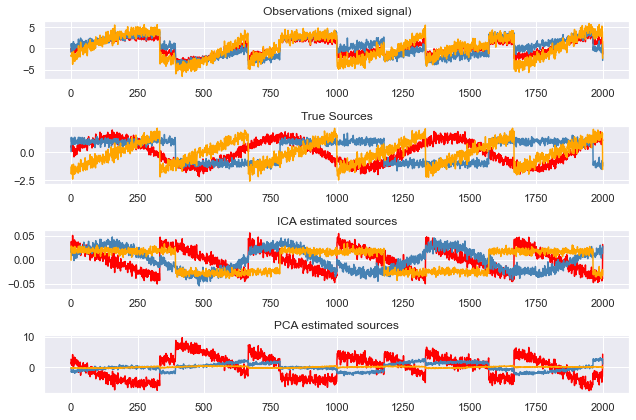

In [153]:
# compute ICA
R = FastICA(n_components=3)
S_ = R.fit_transform(X)  # Get the estimated sources
A_ = R.mixing_  # Get estimated mixing matrix

# compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # estimate PCA sources

plt.figure(figsize=(9, 6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA estimated sources',
         'PCA estimated sources']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

# ICA from scratch
[Link to website](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e)

Individual steps:
1. Center x by subtracting the mean
2. Whiten x
3. Choose a random initial value for the de-mixing matrix w
4. Calculate the new value for w
5. Normalize w
6. Check whether algorithm has converged and if it hasn’t, return to step 4
7. Take the dot product of w and x to get the independent source signals

In [172]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Determining a new value for w
def g(x):
    return np.tanh(x)
def g_der(x):
    return 1 - g(x) * g(x)

# Centering signal by substracting the mean
def center(X):
    X = np.array(X)
    
    mean = X.mean(axis=1, keepdims=True)
    
    return X- mean

# Whitening the signal
def whitening(X):
    cov = np.cov(X)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
    return X_whiten

# Updating the de-mixing matrix
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

Finally we define the main method which calls the preprocessing functions, initializes w to some random set of values and iteratively updates w.

Convergence can be judged by the fact that an ideal w would be orthogonal, and hence w multiplied by its transpose would be approximately equal to 1. After computing the optimal value of w for each component, we take the dot product of the resulting matrix and the signal x to get the sources.

In [173]:
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    
    X = whitening(X)
        
    components_nr = X.shape[0]

    W = np.zeros((components_nr, components_nr), dtype=X.dtype)

    for i in range(components_nr):
        
        w = np.random.rand(components_nr)
        
        for j in range(iterations):
            
            w_new = calculate_new_w(w, X)
            
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            
            if distance < tolerance:
                break
                
        W[i, :] = w
        
    S = np.dot(W, X)
    
    return S

In [232]:
# Function to plot and compare the original, mixed and predicted signals

def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()
    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("Mixtures")
    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("Real sources")
    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("Predicted sources")
    
    fig.tight_layout()
    plt.show()
    
# Function to artificially mix different source signals.

def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        
        max_val = np.max(mixtures[i])
        
        if max_val > 1 or np.min(mixtures[i]) < 1:
            
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

In [233]:
# Creating 3 signals, each with its own distinct pattern

n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.cos(1.2 * time)  # cos
s2 = np.sin(3.35 * time)*np.cos(1.8 * np.pi * time)  # sin
s3 = np.sign(np.sin(1.9 * time))  # square signal
s4 = signal.sawtooth(1.96 * np.pi * time)  # saw tooth signal

In the following example, we compute the dot product of the matrix A and the signals to obtain a combination of all three. We then use Independent Component Analysis to separate the mixed signal into the original source signals.

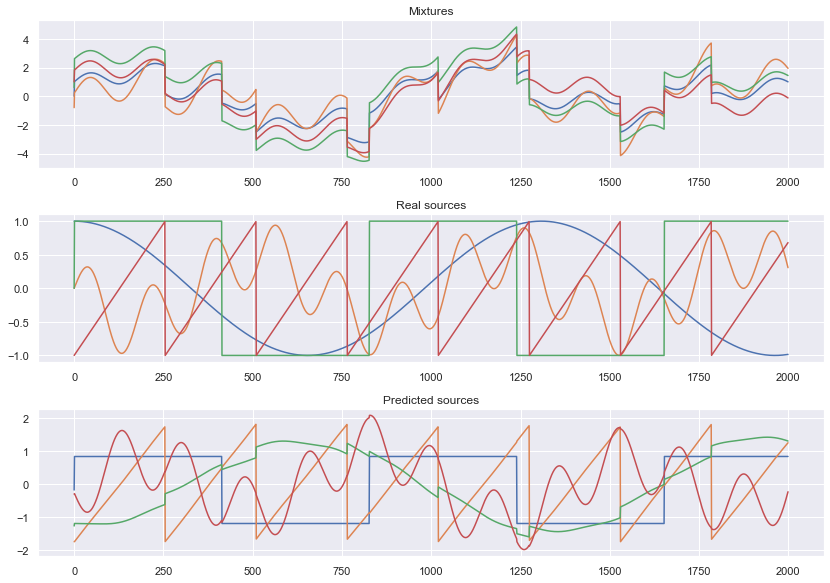

In [234]:
S = np.c_[s1, s2, s3, s4]
A = np.array(([[1, 1, 1, 1], [0.7, 2, 1.0, 1.5], [1.5, 1.0, 2.0, 0.9], [2, 1.2, 0.8, 1]])) # Mixing matrix
X = np.dot(S, A.T) # Generate observations
X = X.T
ICA = ica(X, iterations=6000)
plot_mixture_sources_predictions(X, [s1, s2, s3, s4], ICA)

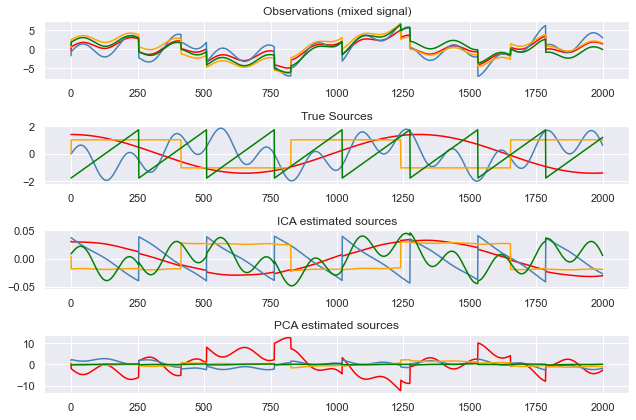

In [218]:
S = np.c_[s1, s2, s3, s4]
S /= S.std(axis=0)  # Standardize data
A = np.array(([[1, 1, 1, 1], [0.7, 2, 1.0, 1.5], [1.5, 1.0, 2.0, 0.9], [2, 1.2, 0.8, 1]])) # Mixing matrix
X = np.dot(S, A.T) # Generate observations

R = FastICA(n_components=4)
S_ = R.fit_transform(X)  # Get the estimated sources
A_ = R.mixing_  # Get estimated mixing matrix
# compute PCA
pca = PCA(n_components=4)
H = pca.fit_transform(X)  # estimate PCA sources

plt.figure(figsize=(9, 6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA estimated sources',
         'PCA estimated sources']
colors = ['red', 'steelblue', 'orange', 'green']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

# Audio Example

Decomposing a mixture of actual audio tracks and ploting the results.

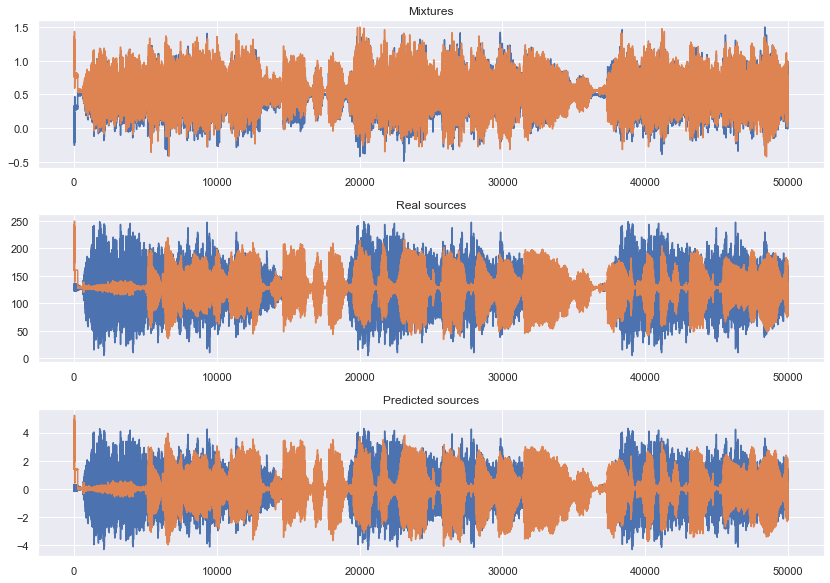

In [160]:
sampling_rate, mix1 = wavfile.read('samples/mix1.wav')
sampling_rate, mix2 = wavfile.read('samples/mix2.wav')
sampling_rate, source1 = wavfile.read('samples/source1.wav')
sampling_rate, source2 = wavfile.read('samples/source2.wav')
X = mix_sources([mix1, mix2])
S = ica(X, iterations=1000)
plot_mixture_sources_predictions(X, [source1, source2], S)
wavfile.write('samples/out1.wav', sampling_rate, S[0])
wavfile.write('samples/out2.wav', sampling_rate, S[1])

# Getting historical stock / crypto data

In [161]:
import pandas as pd # data science
import yfinance as yf # downloading the historical stock prices from yahoo finance
import datetime
import time
import requests
import io
import matplotlib.pyplot as plt

In [162]:
# Stocks
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2021,10,11)
stock = yf.download('TSLA',start=start, end=end, progress=False)
crypto = yf.download(tickers='ADA-USD',period = '8d', interval = '30m')
crypto1 = yf.download(tickers='BTC-USD',start=start, end=end, progress=False)

[*********************100%***********************]  1 of 1 completed


In [163]:
stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-31,128.000000,130.600006,126.503998,130.113998,130.113998,78596500
2020-02-03,134.738007,157.227997,134.703995,156.000000,156.000000,235325000
2020-02-04,176.591995,193.798004,166.776001,177.412003,177.412003,304694000
2020-02-05,164.651993,169.195999,140.822006,146.940002,146.940002,242119000
2020-02-06,139.983994,159.166000,137.399994,149.792007,149.792007,199404000
...,...,...,...,...,...,...
2021-10-04,796.500000,806.969971,776.119995,781.530029,781.530029,30483300
2021-10-05,784.799988,797.309998,774.200012,780.590027,780.590027,18432600
2021-10-06,776.200012,786.659973,773.219971,782.750000,782.750000,14632800


In [164]:
crypto1

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-31,9508.313477,9521.706055,9230.776367,9350.529297,9350.529297,29432489719
2020-02-01,9346.357422,9439.323242,9313.239258,9392.875000,9392.875000,25922656496
2020-02-02,9389.820312,9468.797852,9217.824219,9344.365234,9344.365234,30835736946
2020-02-03,9344.683594,9540.372070,9248.633789,9293.521484,9293.521484,30934096509
2020-02-04,9292.841797,9331.265625,9112.811523,9180.962891,9180.962891,29893183716
...,...,...,...,...,...,...
2021-10-06,51486.664062,55568.464844,50488.191406,55361.449219,55361.449219,49034730168
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,53805.984375,36807860413
2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,53967.847656,34800873924


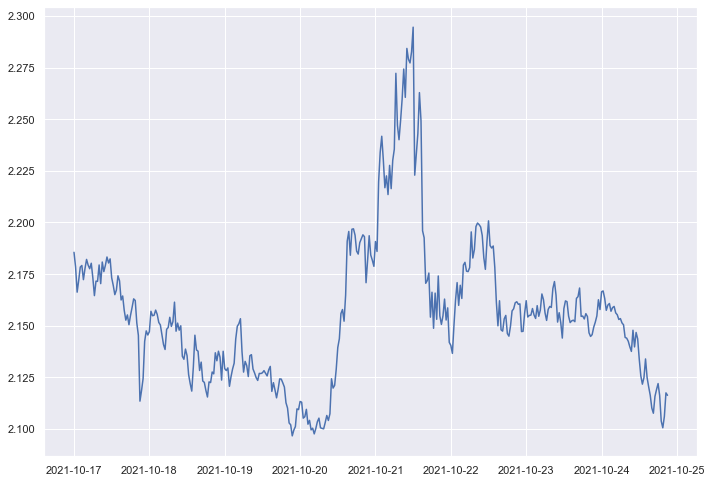

In [165]:
plt.plot(crypto.index,crypto['Close'])

In [182]:
def getpricedata(ticker,period,interval):
    return yf.download(tickers=ticker, period = period, interval = interval)

def normalize(array):
    return (array - np.min(array))/np.ptp(array)

In [240]:
s1 = getpricedata("BTC-USD","12mo","1h")
s2 = getpricedata("ETH-USD","12mo","1h")
s3 = getpricedata("ADA-USD","12mo","1h")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [241]:
n1 = normalize(s1['Close'])
n2 = normalize(s2['Close'])
n3 = normalize(s3['Close'])

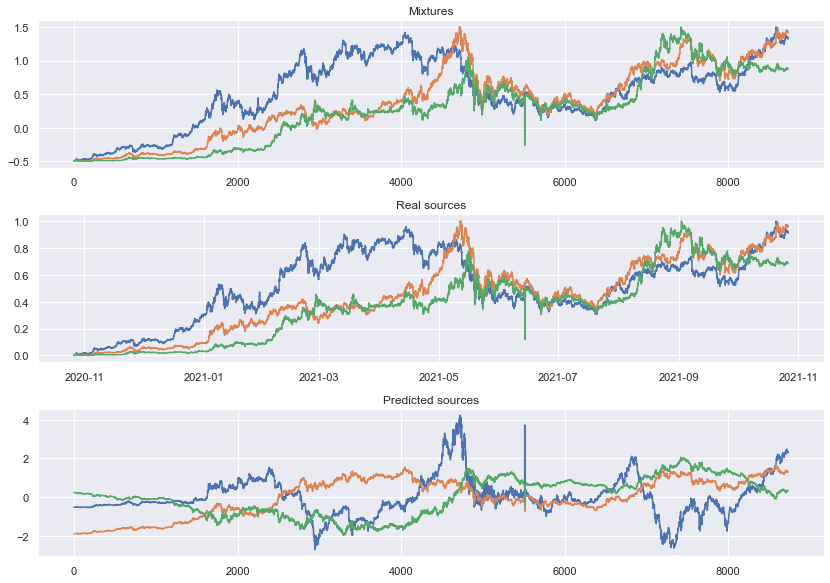

In [242]:
X = mix_sources([n1, n2, n3])
S = ica(X, iterations=2500)
plot_mixture_sources_predictions(X, [n1, n2, n3], S)

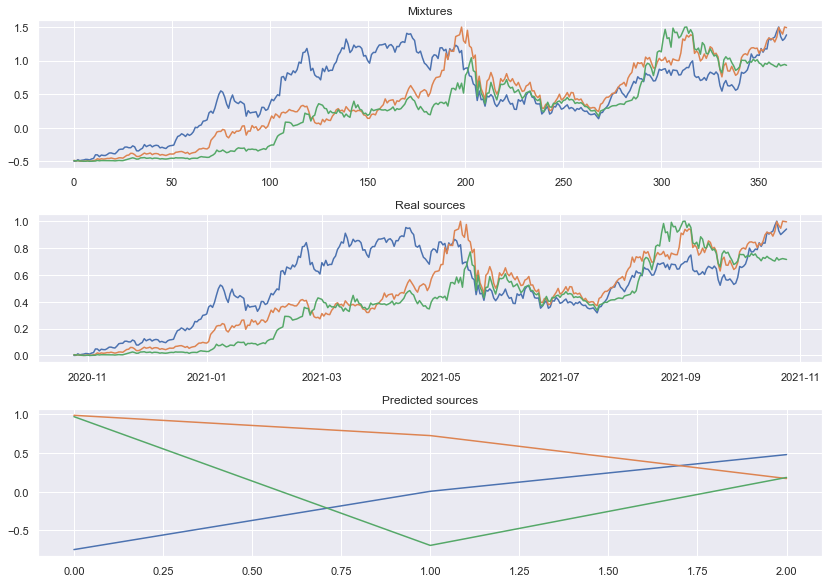

In [238]:
R = FastICA(n_components=3, max_iter=5000)
S_ = R.fit_transform(X)  # Get the estimated sources
plot_mixture_sources_predictions(X, [n1, n2, n3], S_)

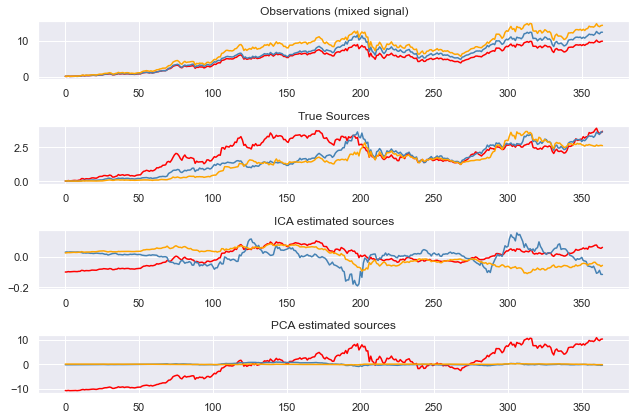

In [239]:
S = np.c_[n1, n2, n3]
S /= S.std(axis=0)  # Standardize data
A = np.array(([[1, 1, 1], [0.7, 2, 1.0], [1.5, 1.0, 2.0]])) # Mixing matrix
X = np.dot(S, A.T) # Generate observations

# compute ICA
R = FastICA(n_components = 3, max_iter = 5000)
S_ = R.fit_transform(X)  # Get the estimated sources
A_ = R.mixing_  # Get estimated mixing matrix

# compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # estimate PCA sources

plt.figure(figsize=(9, 6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA estimated sources',
         'PCA estimated sources']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()